# Visualize the results on practical PIV recordings
- Solid-body rotation in Exp5-1, and homography transformation in Exp5-2

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# PIV method
from pig import AttrDict
from deformpiv import DeformPIV, warping

from fdi2cdi import fdi2cdi
from metrics import PIVmetric, EPE

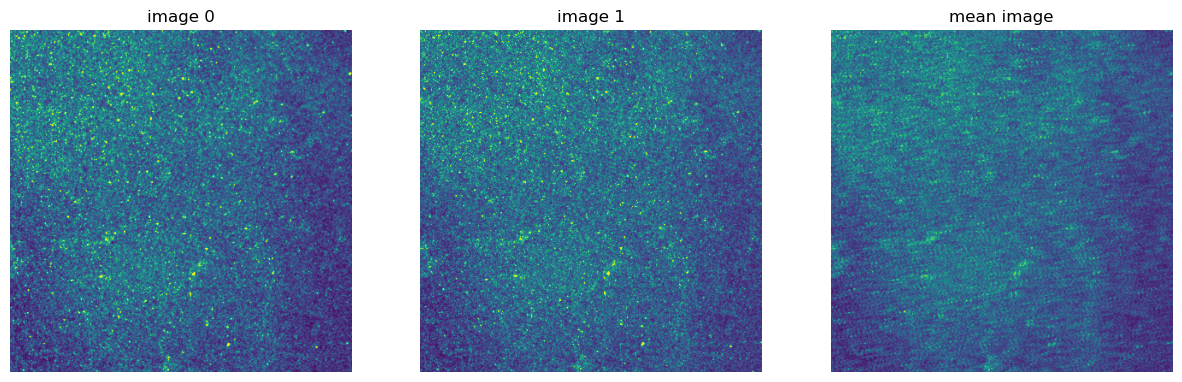

In [2]:
# read real recording data 
path = "./TestImages/real_case2"
img1 = cv2.imread(os.path.join(path,"image1/Image_20240831212454323.bmp"),0) # [340:740,600:1000]
img2 = cv2.imread(os.path.join(path,"image2/Image_20240831212505111.bmp"),0)

img1 = img1[340:740,600:1000] # arbitrary clip to perform an initial offset 
img2 = img2[330:730,140:540]

imgs = [img1,img2]
# show the images
data = np.array(imgs)
img_mean = np.mean(data, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(131); plt.title("image 0")
plt.imshow(imgs[0]); plt.axis("off")
plt.subplot(132); plt.title("image 1")
plt.imshow(imgs[1]); plt.axis("off")
plt.subplot(133); plt.title("mean image")
plt.imshow(img_mean); plt.axis("off")


plt.show()

In [3]:
# Find out the Transform with cv2.findTransformECC()
def Transform(img1, img2):
    # Find size of image1
    sz = img1.shape
    
    # Define the motion model: can be TRANSLATION OR AFFINE OR HOMOGRAPHY
    warp_mode = cv2.MOTION_HOMOGRAPHY
    
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    # Specify the number of iterations.
    number_of_iterations = 5000;
    
    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(img1, img2, warp_matrix, warp_mode, criteria)
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective (img2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(img2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    
    cv2.imwrite("img1.png", img1 )
    cv2.imwrite("img2.png", img2)
    # cv2.imwrite("AlignedEU_IMG.png", im2_aligned )
    return warp_matrix
    
warp_matrix = Transform(imgs[0],imgs[1]) # The matrix reflects the image deformation
print(warp_matrix)

[[ 1.0006716e+00  3.0794635e-04  4.9254847e+00]
 [ 1.3523456e-03  9.9881274e-01 -5.8633500e-01]
 [ 3.5450325e-06 -4.4187948e-07  1.0000000e+00]]


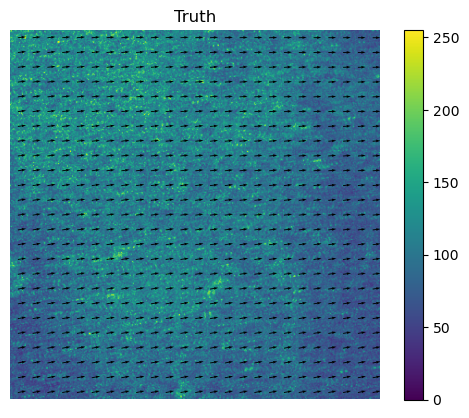

In [4]:
# construct the ground truth for PIV evaluation
def flow_truth(sz, warp_matrix):
    x, y = np.meshgrid(np.arange(sz[0]), np.arange(sz[1]),indexing="ij")
    p0 = np.stack([y,x], axis=-1)+0.0
    p1 = cv2.perspectiveTransform(p0, warp_matrix)
    
    V = p1-p0
    u, v = V[...,1], V[...,0] 
    return x, y, u, v


def plot_vectors(epe, u, v, vmin=0, vmax=0.1):
    x, y = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]), indexing='ij')

    plt.imshow(epe, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.quiver(y[8::16,8::16],x[8::16,8::16],v[8::16,8::16],-u[8::16,8::16])
    plt.axis('off')


x_t, y_t, u_t, v_t = flow_truth(imgs[0].shape,warp_matrix)

plt.figure()
plot_vectors(img_mean, u_t, v_t, vmax=None)
plt.title("Truth")
plt.show()

In [5]:
# perform PIV analysis with OF
config = AttrDict()
config.pivmethod = 'opticalflow' # ['crosscorrelation', 'opticalflow', 'raft_estimator']
config.runs = 6

config.deform = 'FDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_fdi, y_fdi, u_fdi, v_fdi = piv.compute(imgs[0], imgs[1])

config.deform = 'CDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_cdi, y_cdi, u_cdi, v_cdi = piv.compute(imgs[0], imgs[1])

v_fdi2cdi,u_fdi2cdi = fdi2cdi(v_fdi, u_fdi, t=0, delta=1)

# Remove the boundary with width 25
u_fdi, v_fdi = u_fdi[25:-25,25:-25], v_fdi[25:-25,25:-25] 
u_cdi, v_cdi = u_cdi[25:-25,25:-25], v_cdi[25:-25,25:-25]
u_fdi2cdi, v_fdi2cdi = u_fdi2cdi[25:-25,25:-25], v_fdi2cdi[25:-25,25:-25]  
u_t, v_t =  u_t[25:-25,25:-25], v_t[25:-25,25:-25] 

epe_fdi = EPE(u_t, v_t, u_fdi, v_fdi)
epe_cdi = EPE(u_t, v_t, u_cdi, v_cdi)
epe_fdi2cdi = EPE(u_t, v_t, u_fdi2cdi, v_fdi2cdi)


print("FDI (OF):")
res1 = PIVmetric(u_t,v_t,u_fdi,v_fdi)

print("CDI (OF):")
res2 = PIVmetric(u_t,v_t,u_cdi,v_cdi)

print("FDI2CDI (OF):")
res3 = PIVmetric(u_t,v_t,u_fdi2cdi,v_fdi2cdi)

FDI (OF):
0.4249(RMSE)	0.3481(AEE)	0.0344(AAE,rad)	0.8198(SSIM)	0.9974(MoC)	29(Outlier)	
CDI (OF):
0.4520(RMSE)	0.3781(AEE)	0.0359(AAE,rad)	0.8029(SSIM)	0.9975(MoC)	44(Outlier)	
FDI2CDI (OF):
0.4227(RMSE)	0.3465(AEE)	0.0343(AAE,rad)	0.8218(SSIM)	0.9980(MoC)	27(Outlier)	


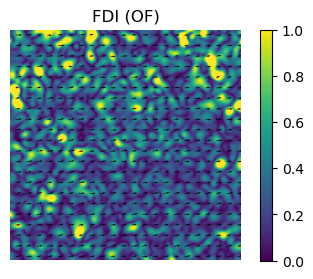

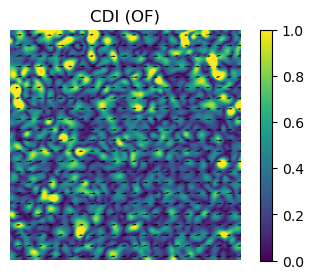

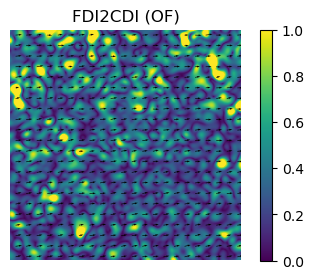

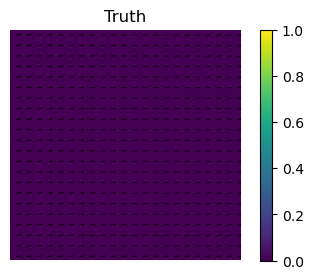

In [6]:
names = ["FDI (OF)", "CDI (OF)", "FDI2CDI (OF)", "Truth"]
epes = [epe_fdi, epe_cdi, epe_fdi2cdi, 0*epe_fdi2cdi]

for k, (u, v) in enumerate([(u_fdi, v_fdi),(u_cdi, v_cdi),(u_fdi2cdi, v_fdi2cdi),(u_t, v_t)]):
    plt.figure(figsize=(5,3))
    plot_vectors(epes[k], u, v, vmax=1.0)
    plt.savefig(f"output/Fig14_{names[k]}.pdf")
    plt.title(names[k])

plt.show()

In [7]:
# perform PIV analysis with CC
config = AttrDict()
config.pivmethod = 'crosscorrelation' # ['crosscorrelation', 'opticalflow', 'raft_estimator']
config.runs = 6

config.deform = 'FDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_fdi, y_fdi, u_fdi, v_fdi = piv.compute(imgs[0], imgs[1])

config.deform = 'CDI' # ['FDI', 'CDI', 'CDDI', 'FDDI']
piv = DeformPIV(config)
x_cdi, y_cdi, u_cdi, v_cdi = piv.compute(imgs[0], imgs[1])

v_fdi2cdi,u_fdi2cdi = fdi2cdi(v_fdi, u_fdi, t=0, delta=1)

# Remove the boundary with width 25
u_fdi, v_fdi = u_fdi[25:-25,25:-25], v_fdi[25:-25,25:-25] 
u_cdi, v_cdi = u_cdi[25:-25,25:-25], v_cdi[25:-25,25:-25]
u_fdi2cdi, v_fdi2cdi = u_fdi2cdi[25:-25,25:-25], v_fdi2cdi[25:-25,25:-25]  

epe_fdi = EPE(u_t, v_t, u_fdi, v_fdi)
epe_cdi = EPE(u_t, v_t, u_cdi, v_cdi)
epe_fdi2cdi = EPE(u_t, v_t, u_fdi2cdi, v_fdi2cdi)


print("FDI (CC):")
res1 = PIVmetric(u_t,v_t,u_fdi,v_fdi)

print("CDI (CC):")
res2 = PIVmetric(u_t,v_t,u_cdi,v_cdi)

print("FDI2CDI (CC):")
res3 = PIVmetric(u_t,v_t,u_fdi2cdi,v_fdi2cdi)

FDI (CC):
0.3294(RMSE)	0.2591(AEE)	0.0235(AAE,rad)	0.8413(SSIM)	1.0138(MoC)	229(Outlier)	
CDI (CC):
0.3576(RMSE)	0.2801(AEE)	0.0261(AAE,rad)	0.8204(SSIM)	1.0130(MoC)	290(Outlier)	
FDI2CDI (CC):
0.3268(RMSE)	0.2577(AEE)	0.0232(AAE,rad)	0.8455(SSIM)	1.0143(MoC)	214(Outlier)	


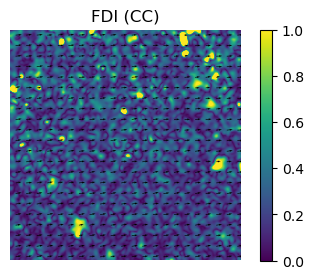

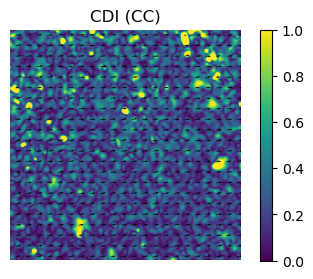

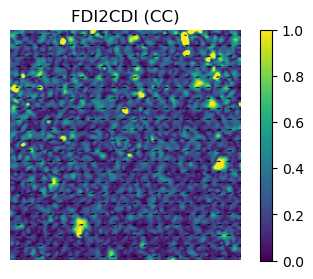

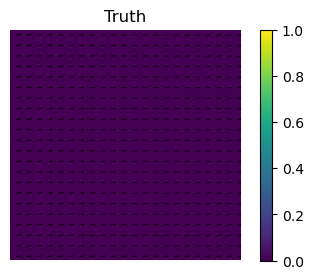

In [8]:
names = ["FDI (CC)", "CDI (CC)", "FDI2CDI (CC)", "Truth"]
epes = [epe_fdi, epe_cdi, epe_fdi2cdi, 0*epe_fdi2cdi]

for k, (u, v) in enumerate([(u_fdi, v_fdi),(u_cdi, v_cdi),(u_fdi2cdi, v_fdi2cdi),(u_t, v_t)]):
    plt.figure(figsize=(5,3))
    plot_vectors(epes[k], u, v, vmax=1.0)
    plt.savefig(f"output/Fig14_{names[k]}.pdf")
    plt.title(names[k])

plt.show()